In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [7]:
import torch
from src.models import BridgeResnet
import os
import json
from torch.nn import Softmax
import matplotlib.pyplot as plt
from shapely.geometry import Point
from notebooks.utils import (get_training_parameters, get_prediction_information, 
                             load_model, get_file_paths_from_notebook_directory, plot_sample)
from src.data import map_indices_to_modalities

# Load model

In [4]:
### Replace with desired save_dir
MODEL_DIR = "../results/resnet50-1200"

In [5]:
MODEL_PATH = os.path.join(MODEL_DIR, "best.pt")

In [8]:
parameters = get_training_parameters(MODEL_DIR)
model_name = parameters.get("model")
data_modalities = parameters.get("data_modalities")
modalities = map_indices_to_modalities(data_modalities)
num_channels = len(modalities)

In [9]:
model = load_model(model_name, MODEL_PATH, num_channels)

# Make Inference in Rwanda

In [10]:
import geopandas as gpd
from src.data import BridgeDataset
from src.data import METADATA, TRAIN_DATA, get_dataloaders, DATA_ORDER, map_indices_to_modalities

In [11]:
rwanda_mask = gpd.read_file("../data/country_masks/rwanda.shp")
rwanda_polygon = rwanda_mask.geometry[0]
rwanda_representative_point = rwanda_polygon.representative_point()

In [12]:
train_data, metadata, stats_fp = get_file_paths_from_notebook_directory()

In [13]:
data = BridgeDataset(data=train_data, raster_data=metadata, stats_fp=stats_fp)

In [14]:
def inference_rwanda(model, lon, lat):
    point = Point(lon, lat)
    if not rwanda_polygon.contains(point):
        raise Exception(f"Point lat: {lat} lon: {lon} not in Rwanda boundaries.")
    input_channels, label = data.get_item_from_lon_lat(lon, lat, "Rwanda")
    prediction, prediction_probabilities = get_prediction_information(model, input_channels)
    print(f"Prediction: {prediction}")
    print(f"NO prediction probability %.2f"%prediction_probabilities[0])
    print(f"YES prediction probability %.2f"%prediction_probabilities[1])
    plot_sample(input_channels[0], modalities)

Prediction: 0
NO prediction probability 0.52
YES prediction probability 0.48


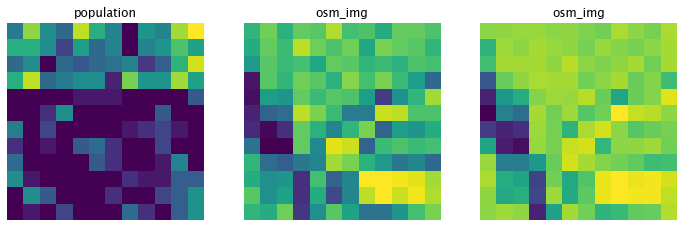

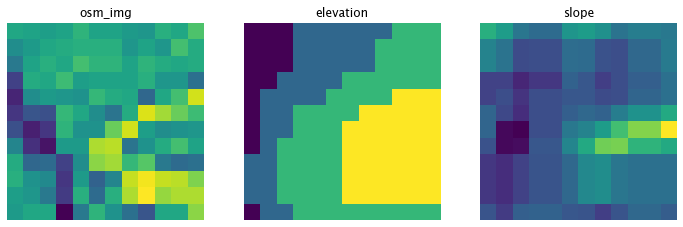

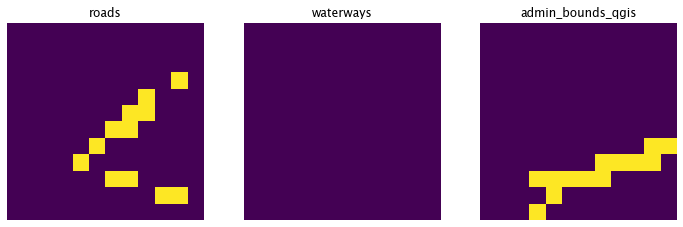

In [41]:
inference_rwanda(model, rwanda_representative_point.x - 0.05, rwanda_representative_point.y + .17)

Prediction: 1
NO prediction probability 0.48
YES prediction probability 0.52


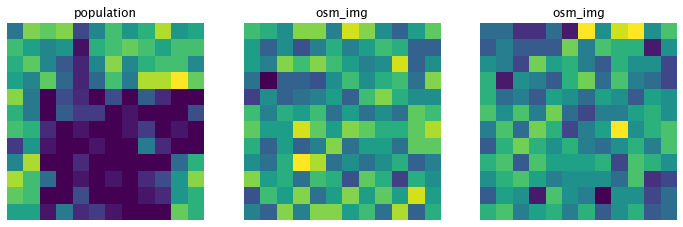

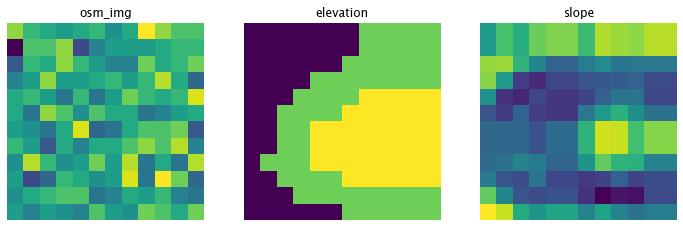

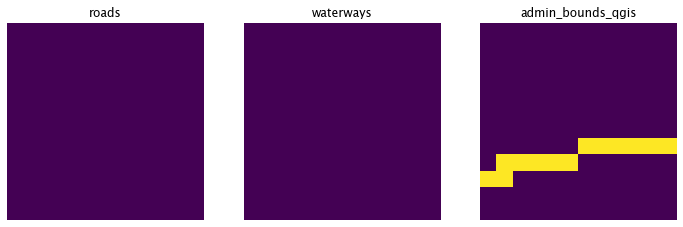

In [72]:
inference_rwanda(model, rwanda_representative_point.x - 0.5, rwanda_representative_point.y)